# Setup

In [1]:
import json
import os
import sys

sys.path.append('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from utils import read_csv_non_utf

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']
ferreiro_arias2024 = config['indiv_data_paths']['ferreiro_arias2024']

ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)
fer_ari_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, ferreiro_arias2024)

In [3]:
# Choosing the dataset - "mammals" or "birds"
dataset = 'mammals'

# Reading in the dataset
if dataset == 'birds':
    data = pd.read_csv(fer_ari_path)
elif dataset == 'mammals':
    data = read_csv_non_utf(ben_lop_path)

data.head()

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.377193,-0.974594,9.839,-1.916,Africa,Gabon,17.07,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.865690,-0.144053,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.05,No,755.8,39.25948,22.0,0.86,81.8
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.833333,-0.182139,9.839,-1.916,Africa,Gabon,17.07,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,0.900862,-0.104234,9.839,-1.916,Africa,Gabon,3940.03,Herb,0.30,No,755.8,39.25948,22.0,0.86,81.8
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",0.956140,-0.044691,9.839,-1.916,Africa,Gabon,17.07,Herb,0.60,No,755.8,39.25948,22.0,0.86,81.8


In [33]:
# Establishing a consistent naming scheme and color palette
model_names_plot = {'FLAML_classification_2mins' : {'name' : 'Nonlinear Classification', 
                                                    'color' : '#ef476f'}, 
                    'FLAML_regression_2mins' : {'name' : 'Nonlinear Regression',
                                                'color' : '#f78c6b'},
                    'sklearn_hurdle' : {'name' : 'Linear Fixed-Effects Hurdle',
                                        'color' : '#97c1a9'},
                    'pymer_hurdle_w_rfx' : {'name' : 'Linear Mixed-Effects Hurdle (w/rfx)',
                                            'color' : '#ffd166'},
                    'pymer_hurdle_wo_rfx' : {'name' : 'Linear Mixed-Effects Hurdle (w/o rfx)',
                                             'color' : '#06d6a0'},
                    'FLAML_hurdle_2mins' : {'name' : 'Nonlinear Hurdle',
                                            'color' : '#118ab2'},
                    'dummy_regressor' : {'name' : 'Naïve Regressor',
                                        'color' : '#073b4c'},
                    'FLAML_hurdle_3mins_BioCLIP+SatCLIP' : {'name' : 'Nonlinear Hurdle (w/embeddings)', 
                                                            'color' : '#c175c7'},
                    'FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP' : {'name' : 'Nonlinear Hurdle (w/embeddings)', 
                                                            'color' : '#d9c875'}
                   }
metric_names_plot = {'balanced_accuracy_overall' : 'Balanced Accuracy$\\uparrow$',
                     'mean_absolute_error' : 'Mean Absolute Error$\\downarrow$',
                     'mean_absolute_error_0-1' : 'Mean Absolute Error\n(0-1 range)$\\downarrow$',
                     'root_mean_squared_error' : 'Root Mean Squared Error$\\downarrow$'}

# Cross-Validation Results

In [31]:
# Load back in cross-val resuls
save_fp = '/Users/emiliolr/Desktop/life-hunting/results'
cv_results = pd.read_csv(os.path.join(save_fp, 'cross_val_results.csv'))

#  choosing metrics to inspect
metrics_to_keep = ['balanced_accuracy_overall', 'mean_absolute_error', 'mean_absolute_error_0-1', 'root_mean_squared_error']
cv_results = cv_results[(cv_results['metric'].isin(metrics_to_keep)) & (cv_results['dataset'] == dataset)]

#  keeping only the most recent entry for a particular run, if there are duplicates
num_obs = cv_results.shape[0]

dup_cols = ['DI_category', 'metric', 'model_name', 'dataset', 'num_folds', 
            'block_type', 'spatial_spacing', 'group_col']
cv_results = cv_results.sort_values('date', ascending = True).drop_duplicates(dup_cols, keep = 'last')

print(f'{num_obs - cv_results.shape[0]} duplicate rows excluded')

#  only inspecting group blocking by species
cv_results = cv_results[(cv_results['group_col'] == 'Species') | (cv_results['block_type'].isin(['random', 'spatial']))]

#  grabbing only the needed columns
cols_to_keep = ['metric', 'mean', 'standard_deviation', 'model_name', 'block_type', 'group_col']
cv_results = cv_results[cols_to_keep]

cv_results = cv_results.sort_values(by = ['block_type', 'model_name', 'metric'])
cv_results.head()

12 duplicate rows excluded


,metric,mean,standard_deviation,model_name,block_type,group_col
211,balanced_accuracy_overall,0.563585,0.010078,FLAML_classification_2mins,group,Species
403,balanced_accuracy_overall,0.511460,0.032982,FLAML_hurdle_2mins,group,Species
404,mean_absolute_error,0.809448,0.125711,FLAML_hurdle_2mins,group,Species
405,mean_absolute_error_0-1,0.309167,0.025149,FLAML_hurdle_2mins,group,Species
406,root_mean_squared_error,3.406656,1.715946,FLAML_hurdle_2mins,group,Species


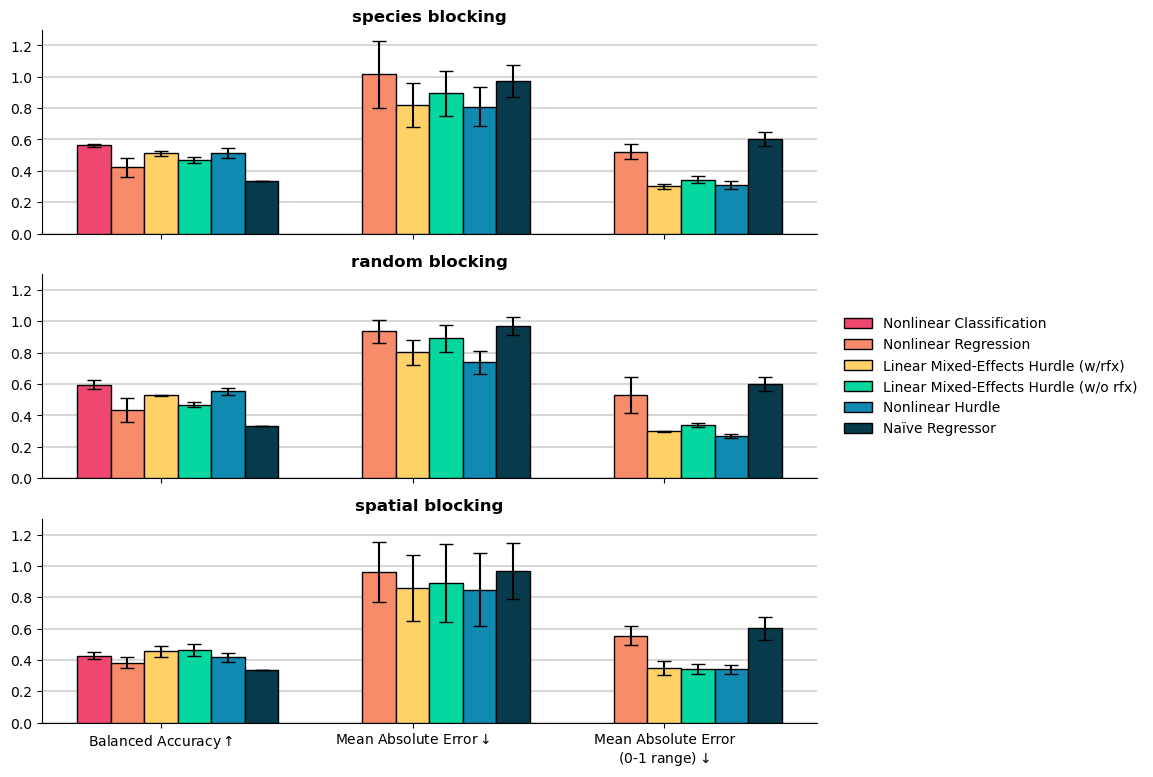

In [48]:
# Plotting results for the above metrics
plot_just_hurdles = False
plot_rmse = False
width = 0.8

metrics = sorted(cv_results[cv_results['model_name'] == 'FLAML_hurdle_2mins']['metric'].unique())
if not plot_rmse:
    metrics.remove('root_mean_squared_error')

blocks = cv_results['block_type'].unique()
if plot_just_hurdles:
    models = ['pymer_hurdle_wo_rfx', 'FLAML_hurdle_2mins', 'FLAML_hurdle_3mins_BioCLIP+SatCLIP',
              'FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP']
else:
    models = ['FLAML_classification_2mins', 'FLAML_regression_2mins', 'pymer_hurdle_w_rfx', 
              'pymer_hurdle_wo_rfx', 'FLAML_hurdle_2mins', 'dummy_regressor']

fig, axs = plt.subplots(3, 1, figsize = (10, 9), sharex = True)

for i, block in enumerate(blocks):
    ax = axs[i]

    ind = np.arange(len(metrics))
    multiplier = 0
    
    for i, model in enumerate(models):
        model_results = cv_results[(cv_results['model_name'] == model) & (cv_results['block_type'] == block) & (cv_results['metric'].isin(metrics))]
        
        means = list(model_results['mean'])
        stds = list(model_results['standard_deviation'])
    
        if model.startswith('FLAML_classification'):
            means.extend([np.nan] * (len(metrics) - 1))
            stds.extend([np.nan] * (len(metrics) - 1))
    
        position = ind + (width / len(models)) * multiplier 
        
        ax.bar(position, means, width / len(models), yerr = stds, capsize = 5, edgecolor = 'black', 
               color = model_names_plot[model]['color'], label = model_names_plot[model]['name'], zorder = 100)
    
        multiplier += 1
    
    ax.set_xticks(ind + (width / 2) - (width / len(models)))
    ax.set_xticklabels([metric_names_plot[m] for m in metrics])

    block_name = 'species' if block == 'group' else block    
    ax.set_title(f'{block_name} blocking', weight = 'bold', size = 12, pad = 6)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5,
            alpha = 0.3)
    ax.set_ylim((0, 1.3))

axs[1].legend(loc = 'center right', bbox_to_anchor = (1.43, 0.5), ncols = 1, frameon = False)
# plt.xlabel('Evaluation Metric', weight = 'bold', size = 12)

# plt.savefig(f'../figures/cv_results_all_blocking_{dataset}.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [49]:
# Highlighting percent improvement in metrics betweeen non-linear vs. linear mixed effects (w/rfx) hurdle
models_to_inspect = ['FLAML_hurdle_2mins', 'FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP', 
                     'pymer_hurdle_wo_rfx', 'dummy_regressor']
to_compare = [(0, 2), (0, 3), (1, 2), (1, 3)]

cv_subset = cv_results[cv_results['model_name'].isin(models_to_inspect)]

for block in blocks:
    block_name = 'species' if block == 'group' else block  
    print_str = f'{block_name.upper()} BLOCKING'
    print(print_str)
    print('-' * len(print_str))

    #  getting the desired metric values for each model
    model_metrics = {m : {} for m in models_to_inspect}
    for metric in metrics_to_keep:
        mask = (cv_subset['metric'] == metric) & (cv_subset['block_type'] == block)

        for m in models_to_inspect:
            model_metrics[m][metric] = cv_subset[mask & (cv_subset['model_name'] == m)]['mean'].iloc[0]

    #  making the desired comparisons
    for comp in to_compare:
        model_a, model_b = models_to_inspect[comp[0]], models_to_inspect[comp[1]]
        print_str = f'{model_a} vs. {model_b}:'
        print('   ' + print_str)
        print('   ' + '-' * len(print_str))
        
        for metric in metrics_to_keep:
            val_a = model_metrics[model_a][metric]
            val_b = model_metrics[model_b][metric]

            pct_diff = round(((val_a - val_b) / val_b) * 100, 2)
            if pct_diff > 0:
                pct_diff = '+' + str(pct_diff) 

            print(f'   {metric}: {pct_diff}%')
        print()
    print()

SPECIES BLOCKING
----------------
   FLAML_hurdle_2mins vs. pymer_hurdle_wo_rfx:
   -------------------------------------------
   balanced_accuracy_overall: +9.19%
   mean_absolute_error: -9.38%
   mean_absolute_error_0-1: -10.13%
   root_mean_squared_error: -1.93%

   FLAML_hurdle_2mins vs. dummy_regressor:
   ---------------------------------------
   balanced_accuracy_overall: +53.44%
   mean_absolute_error: -16.73%
   mean_absolute_error_0-1: -48.59%
   root_mean_squared_error: +0.53%

   FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP vs. pymer_hurdle_wo_rfx:
   ----------------------------------------------------------------
   balanced_accuracy_overall: -11.59%
   mean_absolute_error: -1.83%
   mean_absolute_error_0-1: +8.04%
   root_mean_squared_error: -0.97%

   FLAML_hurdle_3mins_JUST_BioCLIP+SatCLIP vs. dummy_regressor:
   ------------------------------------------------------------
   balanced_accuracy_overall: +24.23%
   mean_absolute_error: -9.79%
   mean_absolute_error_0-1: -38